In [3]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import warnings
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import ssl
from tkinter import *

# creates an SSL context without verifying the authenticity of certificates.
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#nltk.download('stopwords')
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/Users/sofiautoft/research/Recommender_System_TedTalks/tedx_dataset-master/update_2021/tedx_dataset.csv')
df.head()

,idx,main_speaker,title,details,posted,url,num_views,duration
0,7e52bbc6379463aa0a6776d117b5fffd,TED Audio Collective,Introducing Body Stuff with Dr. Jen Gunter,Should you do a juice cleanse? Is it actually ...,Posted May 2021,https://www.ted.com/talks/ted_audio_collective...,0,2:10
1,ab347a6607b551c7f14619ee9656bcf2,Yuko Munakata,The science behind how parents affect child de...,"Parents, take a deep breath: how your kids tur...",Posted May 2021,https://www.ted.com/talks/yuko_munakata_the_sc...,"298,059",17:07
2,8cce2e464d0bb2adc24284a827768dd0,Simon Sinek,"How to discover your ""why"" in difficult times",What has the coronavirus pandemic taught us ab...,Posted May 2021,https://www.ted.com/talks/simon_sinek_how_to_d...,"471,899",15:39
3,20f4c298ad9abaf66827c94a272563fe,Anu Puusa,"The case for co-ops, the invisible giant of th...","Think capitalism is broken? Try cooperativism,...",Posted May 2021,https://www.ted.com/talks/anu_puusa_the_case_f...,"479,554",11:45
4,90d5c9982dea16555c942b1684a9ff50,Orisanmi Burton,What really happened during the Attica Prison ...,"On September 9th 1971, a spontaneous uprising ...",Posted May 2021,https://www.ted.com/talks/orisanmi_burton_what...,"70,122",5:07


In [5]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    #Store important words
    for word in str(text).split():
        word = word.lower()
        
        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

def cleaning_punctuations(text):
	signal = str.maketrans('', '', punctuations_list)
	return text.translate(signal)

def get_similarities(talk_content, data):

	#Transform talk content into a vector
	talk_array1 = vectorizer.transform(talk_content).toarray()

	#Allocate space to store similarity for each row of the dataset.
	sim = []
	pea = []
	for idx, row in data.iterrows():
		details = row['details']

		# Getting vector for current talk_content.
		talk_array2 = vectorizer.transform(
			data[data['details'] == details]['details']).toarray()

		#Calculate cosine similarities
		cos_sim = cosine_similarity(talk_array1, talk_array2)[0][0]

		#Calculate pearson correlation
		pea_sim = pearsonr(talk_array1.squeeze(), talk_array2.squeeze())[0]

		sim.append(cos_sim)
		pea.append(pea_sim)

	return sim, pea

def recommend_talks(talk_content, data):

	title = [talk_content]
	data['cos_sim'], data['pea_sim'] = get_similarities(title, df)

	data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[
					False, False], inplace=True)

	new_df = data[['main_speaker', 'title']]
	print("\033[1m" + "Ted Talks recommended for you since you liked: " + talk_content + "\033[0m")
	for i in range(5):
		print("     Consider the Ted Talk: " + new_df.iloc[i,1] + " by " + new_df.iloc[i, 0])

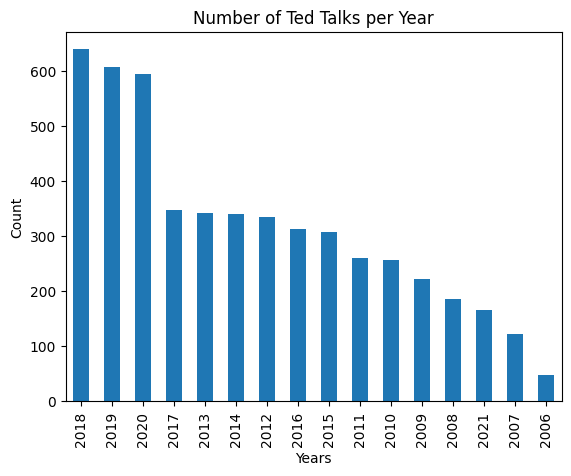

TfidfVectorizer()

In [6]:
splitted = df['posted'].str.split(' ', expand=True)

#Create columns for month and year of the talk
df['year'] = splitted[2].astype('int')
df['month'] = splitted[1]

df['year'].value_counts().plot.bar()
plt.title("Number of Ted Talks per Year")
plt.xlabel("Years")
plt.ylabel("Count")
plt.show()

#Combine the title and the details of the talk.
df['details'] = df['title'] + ' ' + df['details']

# Removing the unnecessary information
data = df[['main_speaker', 'details', 'title']]
data.dropna(inplace = True)

data['details'] = data['details'].apply(lambda text: remove_stopwords(text))

punctuations_list = string.punctuation

data['details'] = data['details'].apply(lambda x: cleaning_punctuations(x))

#Capture similarities
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(data['details'])

In [7]:
#Get input from user
#try:
#    theme = input("Enter the theme of the Ted Talk: ")
#    recommend_talks(theme, df)
#except:
#    print("Error.")

In [8]:
#Create a GUI

def get_input():
    try:
        title = [txt.get()]
        data = df 
        data['cos_sim'], data['pea_sim'] = get_similarities(title, df)

        data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[False, False], inplace=True)

        new_df = data[['main_speaker', 'title']]
        recommendations.delete('1.0', END)
        string = "Ted Talks recommended for you since you liked: " + txt.get() + "\n"
        for i in range(5):
            string += "     Consider the Ted Talk: " + new_df.iloc[i, 1] + " by " + new_df.iloc[i, 0] + "\n"
        recommendations.insert(END, string)
    except Exception as e:
        print("Error:", e)


gui = Tk()
gui.title("Ted Talk Recommender")
gui.geometry('800x300')

menu = Menu(gui)
item = Menu(menu)
item.add_command(label='New')
menu.add_cascade(label='File', menu=item)
gui.config(menu=menu, bg="light gray")

lbl = Label(gui, text="Enter a Theme: ", font=("Times New Roman", 14), bg="light gray")
lbl.grid(row=0, column=0)

txt = Entry(gui, width=20)
txt.grid(row=0, column=1)

submit = Button(gui, text="Get Ted Talks", font=("Times New Roman", 14), fg="Black", bg="Red", command=get_input)
submit.grid(row=0, column=2)

recommendations = Text(gui, width=100, height=10, font=("Times New Roman", 14))
recommendations.grid(row=2, column=0, columnspan=3)

gui.mainloop()